## 1 Prepare training data

In [21]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

tf.reset_default_graph()

# 下載資料到 mnist_data/ 資料夾下
mnist_data = input_data.read_data_sets('mnist_data', one_hot=True, reshape=False, validation_size=0)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


## 2 Create computal gragh

> y = softmax(weights * x + biases)

In [22]:
x = tf.placeholder(tf.float32, [None, 28, 28, 1], name='input_image')
y = tf.placeholder(tf.float32, [None, 10], name='y')

# 10個神經元 784px image
weights = tf.Variable(tf.zeros([784, 10]), name='weights')
biases = tf.Variable(tf.zeros([10]), name='biases')

In [23]:
flatten_x = tf.reshape(x, [-1, 784], name='flatten_x')
# [784, 10] x [100, 784] ==> Fail
# [100, 784] x [784, 10] ==> [100, 10]
# W x X
wx = tf.matmul(flatten_x, weights, name='wx') # [100, 10]
# WX + biases ==> 答案 v [-1, 10]
final_y = tf.nn.softmax(wx + biases, name='prediction') # [100, 10]
# [100, 10] --> 100張圖, 個別label的信心程度

## 3 Loss function

In [24]:
# Cross-entropy(適合分類): loss = - sum(y * log(finalY))

# MARK: y * tf.log(final_y)
# A = [[1, 2], [3, 4]] ==> Shape: [2, 2]
# B = [[5, 6], [7, 8]] ==> Shape: [2, 2]
# A * B = [[1 * 5,  2 * 6], [3 * 7, 4 * 8]] ==> Shape: [2, 2]

# y ==> Shape: [None, 10]
# finalY ==> Shape: [None, 10]
# tf.log(finalY) ==> Shape: [None, 10]
# y * tf.log(finalY) ==> Shape: [None, 10]

# tf.reduce_mean(..., axis = 0) ==> [10]
# 10 ==> 10種結果, 100 ==> 一次100張圖片

# cross entropy: loss = - sum(Y * log(finalY))
loss = - tf.reduce_mean(y * tf.log(final_y)) * 10 * 100
train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss=loss)


### Extra job for accuracy.

In [25]:
correct_prediction = tf.equal(
    tf.arg_max(final_y, 1),
    tf.arg_max(y, 1)
) # True or False => [100] [T, F, T, F, ....]

accuracy = tf.reduce_mean(
    tf.cast(correct_prediction, tf.float32) # 轉型成float32
)

## 4 Run the session

In [26]:
accuracy_results = []
loss_results = []

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for step in range(2000):
        # Get the training data from file
        batch_x, batch_y = mnist_data.train.next_batch(100)
        session.run(train, feed_dict={
            x: batch_x,
            y: batch_y
        })
        # train 
        accuracy_batch, loss_batch = session.run([accuracy, loss], feed_dict={
            x: batch_x,
            y: batch_y
        })
        # test
        test_x = mnist_data.test.images
        test_y = mnist_data.test.labels
        accuracy_test, loss_test = session.run([accuracy, loss], feed_dict={
            x: test_x,
            y: test_y
        })

        accuracy_results.append({'accuracy_batch': accuracy_batch, 'accuracy_test': accuracy_test})
        loss_results.append({'loss_batch': loss_batch, 'loss_test': loss_test})

In [27]:
%matplotlib inline

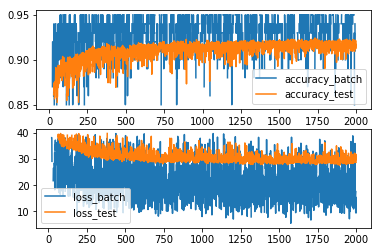

In [28]:
import pandas
import matplotlib.pyplot as plt

pd = pandas.DataFrame(accuracy_results)
pd2 = pandas.DataFrame(loss_results)

pd = pd[(pd > 0.85) & (pd < 0.95)]
pd2 = pd2[pd2 < 40]

fig, axes = plt.subplots(nrows=2, ncols=1)

pd.plot(ax=axes[0])
pd2.plot(ax=axes[1])

## 5 Save

In [29]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # Saver 必須在session還存在的情況使用
    saver = tf.train.Saver()
    
    for step in range(2000):
        # Get the training data from file
        batch_x, batch_y = mnist_data.train.next_batch(100)
        session.run(train, feed_dict={
            x: batch_x,
            y: batch_y
        })
        # train 
        accuracy_batch, loss_batch = session.run([accuracy, loss], feed_dict={
            x: batch_x,
            y: batch_y
        })
        # test
        test_x = mnist_data.test.images
        test_y = mnist_data.test.labels
        accuracy_test, loss_test = session.run([accuracy, loss], feed_dict={
            x: test_x,
            y: test_y
        })
        
    # save gragh/variables.
    saver.save(session, './save/hand_write.ckpt')

## 6 Restore

In [30]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

tf.reset_default_graph()

# 下載資料到 mnist_data/ 資料夾下
mnist_data = input_data.read_data_sets('mnist_data', one_hot=True, reshape=False, validation_size=0)

x = tf.placeholder(tf.float32, [None, 28, 28, 1], name='input_image')
y = tf.placeholder(tf.float32, [None, 10], name='y')

# 10個神經元 784px image
weights = tf.Variable(tf.zeros([784, 10]), name='weights')
biases = tf.Variable(tf.zeros([10]), name='biases')

flatten_x = tf.reshape(x, [-1, 784], name='flatten_x')
wx = tf.matmul(flatten_x, weights, name='wx') # [100, 10]
final_y = tf.nn.softmax(wx + biases, name='prediction') # [100, 10]

loss = - tf.reduce_mean(y * tf.log(final_y)) * 10 * 100
train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss=loss)

correct_prediction = tf.equal(
    tf.arg_max(final_y, 1),
    tf.arg_max(y, 1)
) # True or False => [100] [T, F, T, F, ....]

accuracy = tf.reduce_mean(
    tf.cast(correct_prediction, tf.float32) # 轉型成float32
)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # Saver 必須在session還存在的情況使用
    saver = tf.train.Saver()
    
    # Try restore *.ckpt
    exist = tf.train.get_checkpoint_state('./save/')
    
    if exist:
        saver.restore(session, './save/hand_write.ckpt')
        print('Restore ok.')
    else:
        print('No exist checkpoint.')
    
    # for step in range(2000):
        ## Get the training data from file
        # batch_x, batch_y = mnist_data.train.next_batch(100)
        # session.run(train, feed_dict={x: batch_x, y: batch_y})
        ## train 
        # accuracy_batch, loss_batch = session.run([accuracy, loss], feed_dict={x: batch_x, y: batch_y})
        ## test
        # test_x = mnist_data.test.images
        # test_y = mnist_data.test.labels
        # accuracy_test, loss_test = session.run([accuracy, loss], feed_dict={x: test_x, y: test_y})

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from ./save/hand_write.ckpt
Restore ok.


## Freeze

In [32]:
import tensorflow as tf
from tensorflow.python.framework import graph_util
import tfcoreml as tfconverter


with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # Saver 必須在session還存在的情況使用
    saver = tf.train.Saver()
    
    for step in range(2000):
        # Get the training data from file
        batch_x, batch_y = mnist_data.train.next_batch(100)
        session.run(train, feed_dict={
            x: batch_x,
            y: batch_y
        })
        # train 
        accuracy_batch, loss_batch = session.run([accuracy, loss], feed_dict={
            x: batch_x,
            y: batch_y
        })
        # test
        test_x = mnist_data.test.images
        test_y = mnist_data.test.labels
        accuracy_test, loss_test = session.run([accuracy, loss], feed_dict={
            x: test_x,
            y: test_y
        })
        
    # save gragh/variables.
    saver.save(session, './save/hand_write.ckpt')
    
    # Freeze and save as a pb file.
    frozen_gragh = graph_util.convert_variables_to_constants(session, session.graph_def, [final_y.op.name])
    
    # Check and let None beacome 1.去除None才不會失敗
    for node in frozen_gragh.node:
        if node.device:
            node.device = ''
        if 'shape' in node.attr:
            node.attr['shape'].shape.dim[0].size = 1
    # Save the pb file
    tf.train.write_graph(frozen_gragh, '', './frozen/frozen_gragh.pb', as_text=False)
    

INFO:tensorflow:Froze 2 variables.
INFO:tensorflow:Converted 2 variables to const ops.

Loading the TF graph...
Graph Loaded.
Done.
Now finding ops in the TF graph that can be dropped for inference
Now starting translation to CoreML graph.
Automatic shape interpretation succeeded for input blob input_image:0
1/10: Analysing op name: flatten_x/shape ( type:  Const )
2/10: Analysing op name: biases ( type:  Const )
3/10: Analysing op name: biases/read ( type:  Identity )
4/10: Analysing op name: weights ( type:  Const )
5/10: Analysing op name: weights/read ( type:  Identity )
6/10: Analysing op name: input_image ( type:  Placeholder )
Skipping name of placeholder
7/10: Analysing op name: flatten_x ( type:  Reshape )
8/10: Analysing op name: wx ( type:  MatMul )
9/10: Analysing op name: add ( type:  Add )
10/10: Analysing op name: prediction ( type:  Softmax )
Translation to CoreML spec completed. Now compiling and saving the CoreML model.

 Core ML model generated. Saved at location: ./

input {
  name: "input_image__0"
  type {
    imageType {
      width: 28
      height: 28
      colorSpace: GRAYSCALE
    }
  }
}
output {
  name: "prediction__0"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "prediction__0"

In [33]:
# Convert pb to CoreML file format.
tfconverter.convert(tf_model_path='./frozen/frozen_gragh.pb',
                    mlmodel_path='./model_output/MyHandWriteV1.mlmodel',
                    output_feature_names=['prediction:0'],
                    image_input_names='input_image__0',
                    class_labels='MyHandWriteV1.txt')


Loading the TF graph...
Graph Loaded.
Done.
Now finding ops in the TF graph that can be dropped for inference
Now starting translation to CoreML graph.
Automatic shape interpretation succeeded for input blob input_image:0
1/10: Analysing op name: flatten_x/shape ( type:  Const )
2/10: Analysing op name: biases ( type:  Const )
3/10: Analysing op name: biases/read ( type:  Identity )
4/10: Analysing op name: weights ( type:  Const )
5/10: Analysing op name: weights/read ( type:  Identity )
6/10: Analysing op name: input_image ( type:  Placeholder )
Skipping name of placeholder
7/10: Analysing op name: flatten_x ( type:  Reshape )
8/10: Analysing op name: wx ( type:  MatMul )
9/10: Analysing op name: add ( type:  Add )
10/10: Analysing op name: prediction ( type:  Softmax )
Translation to CoreML spec completed. Now compiling and saving the CoreML model.

 Core ML model generated. Saved at location: ./model_output/MyHandWriteV1.mlmodel 

Core ML input(s): 
 [name: "input_image__0"
type {

input {
  name: "input_image__0"
  type {
    imageType {
      width: 28
      height: 28
      colorSpace: GRAYSCALE
    }
  }
}
output {
  name: "prediction__0"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "prediction__0"